# 【課題】高エネルギー実験で生成された荷電粒子の飛跡を見つける

必要なライブラリを最初にインポートします。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
#from qiskit_optimization.applications import sample_most_likely
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import QuantumInstance

from collections import OrderedDict
from qiskit.opflow import StateFn
def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector (numpy.ndarray or dict): state vector or counts.
    Returns:
        numpy.ndarray: binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, (OrderedDict, dict)):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x

### 問題

以上のデータから、VQEで用いるハミルトニアンを構成してみてください。

**ヒント1**：この形式のデータを以下のコードを使って読み込むとします。

In [2]:
file_r = 'data/QUBO_05pct_input.txt'
from ast import literal_eval
with open(file_r, "r") as f:
    line = f.read()
    Q = literal_eval(line)
print("Q size =",len(Q))

n_max = 100

nvar = 0
key_i = []
b_ij = np.zeros((n_max,n_max))
for (k1, k2), v in Q.items():
    if k1 == k2:
        b_ij[nvar][nvar] = v
        key_i.append(k1)
        nvar += 1

for (k1, k2), v in Q.items():
    if k1 != k2:
        for i in range(nvar):
            for j in range(nvar):
                if k1 == key_i[i] and k2 == key_i[j]:
                    if i < j:
                        b_ij[i][j] = v
                    else:
                        b_ij[j][i] = v

b_ij = b_ij[:nvar,:nvar]
print("# of segments =",nvar)

Q size = 46
# of segments = 10


**ヒント2**：まず、{0,1}のバイナリー値を持つ$T$を{+1,-1}をもつスピン$s$に変換します。$T=0$を$s=1$、$T=1$を$s=-1$に対応させるとします。この関係の下で、目的関数$O$を

$$
H(h,J,s) = \sum_{i=1}^Nh_is_i + \sum_{i=1}^N\sum_{j=1\:(i<j)}^NJ_{ij}s_is_j
$$

となるような関数$H$に書き換えてみてください。この関数$H$はイジング模型のハミルトニアンと同じ形になっています。

In [3]:
from qiskit.quantum_info import Pauli
from qiskit.opflow import PrimitiveOp

##################
### EDIT BELOW ###
##################

# ステップ１：{0,1}を取るTに対して定義されているb_ijを、{+1,-1}を取る変数sに対して定義しなおす。
J_ij = np.zeros((nvar,nvar))
for i in range(nvar):
    for j in range(nvar):
        if i >= j:
            continue
        J_ij[i][j] = b_ij[i][j]+b_ij[j][i]
        if J_ij[i][j] == 0:
            continue

h_i = np.zeros(nvar)
for i in range(nvar):
    bias = 0
    for k in range(nvar):
        bias += b_ij[i][k]+b_ij[k][i]
    bias *= -1
    h_i[i] = bias
    if h_i[i] == 0:
        continue

# ステップ２：変数sをパウリZ演算子を使って実装する。
def get_qubitops(J_ij,h_i,penalty=1e6):
    num_qubits = len(h_i)
    print("Number of qubits (selected triplets) =",num_qubits)
    weighted_sum = 0

    zero = np.zeros(num_qubits, dtype=bool)
    for i in range(num_qubits):
        for j in range(num_qubits):
            if i >= j:
                continue
            if J_ij[i][j] == 0:
                continue
            print("J_ij[",i,"][",j,"]=",J_ij[i][j])
            vp = np.zeros(num_qubits, dtype=bool)
            vp[i] = True
            vp[j] = True
            weighted_sum += J_ij[i][j]*PrimitiveOp(Pauli(vp, zero))

    zero = np.zeros(num_qubits, dtype=bool)
    for i in range(num_qubits):
        print("h_i[",i,"]=",h_i[i])
        vp = np.zeros(num_qubits, dtype=bool)
        vp[i] = True
        weighted_sum += h_i[i]*PrimitiveOp(Pauli(vp, zero))

    return weighted_sum

#def get_qubitops(...):
#
#
#    return ??

##################
### EDIT ABOVE ###
##################

このコードの部分を課題として提出してください。

**ヒント3**：get_qubitopsは、パウリ$Z$演算子を使って実装した観測量$H$を返す関数です。Qiskitでパウリ$Z$演算子とそのテンソル積を実装するには、qiskit.quantum_info.Pauliクラス（[ここ](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Pauli.html)を参照）とqiskit.aqua.operatorsライブラリ（[ここ](https://qiskit.org/documentation/apidoc/qiskit.aqua.operators.html)を参照）を使うのが便利です。セグメント間の相互作用の強さを表す$J_{ij}$は、2つのパウリ$Z$演算子のテンソル積に対する係数として導入する必要があります。それをqiskit.quantum_info.Pauliを使ってどのように書くでしょうか？$h_i$は単一パウリ$Z$演算子の係数になります。そして、最終的に測定する観測量$H$は、それらパウリ$Z$演算子の線形結合になりますね。

### VQEによる近似解の探索

上で定義したハミルトニアンを元に、VQEを使ってエネルギーの最小固有値（の近似解）を求めていきます。ただその前に、このハミルトニアンの行列を対角化して、エネルギーの最小固有値とその固有ベクトルを厳密に計算した場合の答えを出してみましょう。

In [4]:
# ハミルトニアンオペレータを取得
##################
### EDIT BELOW ###
##################

qubitOp = get_qubitops(J_ij, h_i)

##################
### EDIT ABOVE ###
##################
print("")
print("total number of qubits = ",qubitOp.num_qubits)

# ハミルトニアン行列を対角化して、エネルギーの最小固有値と固有ベクトルを求める
#ee  = NumPyMinimumEigensolver(qubitOp)
#result = ee.run()
ee  = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(operator=qubitOp)

# 最小エネルギーに対応する量子ビットの組み合わせを表示
print('Eigensolver: objective =', result.eigenvalue.real)
x = sample_most_likely(result.eigenstate)
print('Eigensolver: x =',x)

samples_eigen = {}
for i in range(nvar):
    samples_eigen[key_i[i]] = x[i]

Number of qubits (selected triplets) = 10
J_ij[ 0 ][ 1 ]= 1.0
J_ij[ 0 ][ 3 ]= 1.0
J_ij[ 0 ][ 4 ]= 1.0
J_ij[ 0 ][ 5 ]= 1.0
J_ij[ 0 ][ 6 ]= -0.2422171861077038
J_ij[ 0 ][ 8 ]= 1.0
J_ij[ 0 ][ 9 ]= 1.0
J_ij[ 1 ][ 2 ]= -0.20194633024258613
J_ij[ 1 ][ 3 ]= 1.0
J_ij[ 1 ][ 4 ]= 1.0
J_ij[ 1 ][ 5 ]= 1.0
J_ij[ 1 ][ 6 ]= 1.0
J_ij[ 1 ][ 7 ]= 1.0
J_ij[ 1 ][ 8 ]= 1.0
J_ij[ 1 ][ 9 ]= -0.24622296145101896
J_ij[ 2 ][ 4 ]= 1.0
J_ij[ 2 ][ 5 ]= 1.0
J_ij[ 2 ][ 6 ]= -0.8163519177517079
J_ij[ 2 ][ 7 ]= 1.0
J_ij[ 3 ][ 4 ]= 1.0
J_ij[ 3 ][ 5 ]= 1.0
J_ij[ 3 ][ 6 ]= -0.9622918217115106
J_ij[ 3 ][ 7 ]= -0.22174336478384057
J_ij[ 3 ][ 8 ]= -0.9698465871822172
J_ij[ 3 ][ 9 ]= 1.0
J_ij[ 4 ][ 5 ]= -0.2093159882343949
J_ij[ 4 ][ 6 ]= 1.0
J_ij[ 4 ][ 7 ]= 1.0
J_ij[ 4 ][ 8 ]= -0.24685399312094367
J_ij[ 4 ][ 9 ]= 1.0
J_ij[ 5 ][ 6 ]= 1.0
J_ij[ 5 ][ 7 ]= 1.0
J_ij[ 6 ][ 7 ]= 1.0
J_ij[ 6 ][ 9 ]= 1.0
J_ij[ 7 ][ 9 ]= 1.0
J_ij[ 8 ][ 9 ]= 1.0
h_i[ 0 ]= -5.780035929747845
h_i[ 1 ]= -6.554566686862729
h_i[ 2 ]= -2.5507675951639466
h_

xのリストで1になっている量子ビット（セグメント）が、最小エネルギーに対応するものとして選ばれているのが分かります。

次に、同じハミルトニアンモデルをVQEに実装して、最小エネルギーを求めてみます。オプティマイザーとしてSPSAあるいはCOBYLAを使う場合のコードは以下のようになります。

まず最初に、VQE用の量子回路を作ります。

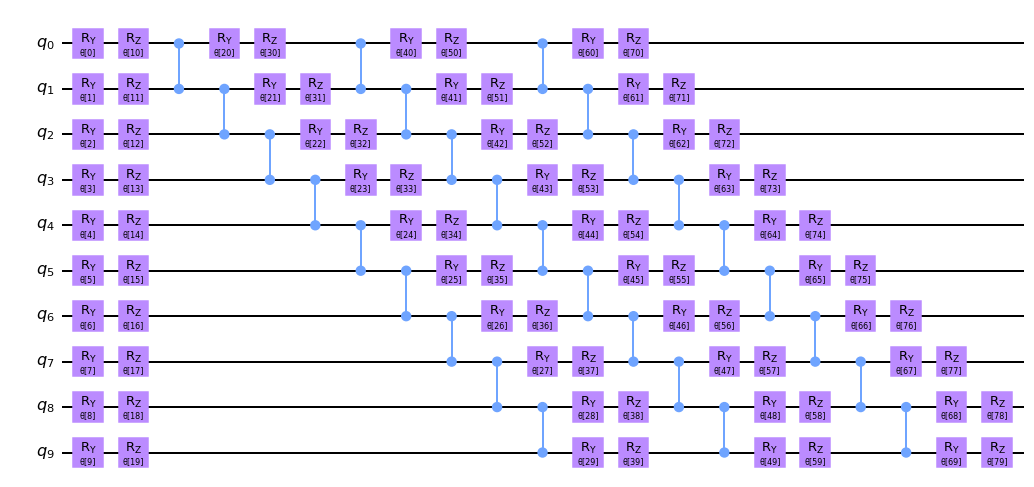

In [5]:
# VQE用の回路を作る：ここではTwoLocalという組み込み関数を使う
seed = 10598
spsa = SPSA(maxiter=300)
cobyla = COBYLA(maxiter=500)
#ansatz = TwoLocal(num_qubits=qubitOp.num_qubits, rotation_blocks=['ry'], entanglement_blocks='cz', entanglement='linear', reps=1)
ansatz = TwoLocal(num_qubits=qubitOp.num_qubits, rotation_blocks=['ry','rz'], entanglement_blocks='cz', entanglement='linear', reps=3)
ansatz.decompose().draw('mpl')

バックエンドしてqasm_simulatorを使い、実行した結果を書き出します。

In [6]:
# VQEの実行
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=4096, seed_simulator=seed)
#vqe = VQE(ansatz, optimizer=spsa, quantum_instance=quantum_instance)
vqe = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)
result = vqe.compute_minimum_eigenvalue(operator=qubitOp)

# 最小エネルギーに対応する量子ビットの組み合わせを表示
print('')
print('VQE: objective =', result.eigenvalue.real)
x = sample_most_likely(result.eigenstate)
print('VQE x =',x)

samples_vqe = {}
for i in range(nvar):
    samples_vqe[key_i[i]] = x[i]


VQE: objective = -31.651225467148127
VQE x = [0 0 1 1 0 0 1 0 1 0]


### おまけ

Trackingがうまく行っても、この答えだと0と1が並んでいるだけで面白くないですよね。正しく飛跡が見つかったかどうか目で確認するため、以下のコードを走らせてみましょう。

このコードは、QUBOを定義する時に使った検出器のヒット位置をビーム軸に垂直な平面でプロットして、どのヒットが選ばれたかを分かりやすく可視化したものです。緑の線が実際に見つかった飛跡で、青の線を含めたものが全体の飛跡の候補です。この実習では限られた数の量子ビットしか使っていないため、大部分の飛跡は見つけられていませんが、緑の線から計算に使った3点ヒットからは正しく飛跡が見つかっていることが分かると思います。

In [12]:
from hepqpr.qallse import *
input_path = './data/event000001000-hits.csv'
dw = DataWrapper.from_path(input_path)

# get the results
#all_doublets = Qallse.process_sample(samples_eigen)
all_doublets = Qallse.process_sample(samples_vqe)

final_tracks, final_doublets = TrackRecreaterD().process_results(all_doublets)
#print("all_doublets =",all_doublets)
#print("final_tracks =",final_tracks)
#print("final_doublets =",final_doublets)

p, r, ms = dw.compute_score(final_doublets)
trackml_score = dw.compute_trackml_score(final_tracks)

print(f'SCORE  -- precision (%): {p * 100}, recall (%): {r * 100}, missing: {len(ms)}')
print(f'          tracks found: {len(final_tracks)}, trackml score (%): {trackml_score * 100}')

from hepqpr.qallse.plotting import iplot_results, iplot_results_tracks
dims = ['x', 'y']
_, missings, _ = diff_rows(final_doublets, dw.get_real_doublets())
dout = 'plot-ising_found_tracks.html'
iplot_results(dw, final_doublets, missings, dims=dims, filename=dout)

ModuleNotFoundError: No module named 'hepqpr'

**提出するもの**
- ハミルトニアンを実装する部分のコード